In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os

In [2]:
# load data
dataDir = "D:/MHC/2022/개인자료/kmong/battery_health_등푸른비행선/tf to torch/PhyCNN/data/"
mat = scipy.io.loadmat(dataDir + 'data_num.mat')

ag_data = mat['input_tf']  # ag, ad, av
u_data = mat['target_X_tf']
ut_data = mat['target_Xd_tf']
utt_data = mat['target_Xdd_tf']
ag_data = ag_data.reshape([ag_data.shape[0], ag_data.shape[1], 1])
u_data = u_data.reshape([u_data.shape[0], u_data.shape[1], 1])
ut_data = ut_data.reshape([ut_data.shape[0], ut_data.shape[1], 1])
utt_data = utt_data.reshape([utt_data.shape[0], utt_data.shape[1], 1])

t = mat['time']
dt = t[0, 1] - t[0, 0]

ag_all = ag_data
u_all = u_data
u_t_all = ut_data
u_tt_all = utt_data

# finite difference
n = u_data.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
Phi_t = 1 / dt * np.concatenate(
        [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)

ag_star = ag_all[0:10]
eta_star = u_all[0:10]
eta_t_star = u_t_all[0:10]
eta_tt_star = u_tt_all[0:10]
g_star = -eta_tt_star -ag_star
lift_star = -ag_star

N_train = eta_star.shape[0]

eta = eta_star
ag = ag_star
lift = lift_star
eta_t = eta_t_star
eta_tt = eta_tt_star
g = g_star

# Training Data
eta_train = eta
ag_train = ag
lift_train = lift
eta_t_train = eta_t
eta_tt_train = eta_tt
g_train = g


In [3]:
class CNN(nn.Module):
    def __init__(self,  numout):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=40, stride=1, padding=20),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=40, stride=1, padding=20),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=40, stride=1, padding=20),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=40, stride=1, padding=20),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=40, stride=1, padding=20),
            nn.ReLU()
        )

        self.output_layer = nn.Sequential(nn.Linear(64, 50),
                                          nn.ReLU(),
                                          nn.Linear(50, 50),
                                          nn.ReLU(),
                                          nn.Linear(50, 3*numout))

    def forward(self, x_in):
        x = x_in.permute(0, 2, 1)
        x = self.conv(x)
        x = x[:, :, :1001]
        x = x.permute(0, 2, 1)
        out = self.output_layer(x)
        return out

In [4]:
eta, eta_t, g, ag, lift, Phi_t = eta_train, eta_t_train, g_train, ag_train, lift_train, Phi_t

learning_rate = 0.001 # 초기 학습률 지정

eta_torch = torch.from_numpy(eta).float()
eta_t_torch = torch.from_numpy(eta_t).float()

g_torch = torch.from_numpy(g).float()
ag_torch = torch.from_numpy(ag).float()
lift_torch = torch.from_numpy(lift).float()

model = CNN(numout=eta.shape[2])
eta_torch.requires_grad = True
eta_t_torch.requires_grad = True
g_torch.requires_grad = True
ag_torch.requires_grad = True
lift_torch.requires_grad = True

optimizer_Adam = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
output = model(ag_torch)
eta = output[:, :, 0:1]
eta_dot = output[:, :, 1:2]
g = output[:, :, 2:]

Phi_ut = Phi_t.reshape(1, eta.shape[1], eta.shape[1])
Phi_ut = Phi_ut.repeat(eta.shape[0], axis=0)
eta_t = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta)
eta_tt = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_dot)

lift = eta_tt + g

In [6]:
def criterion(eta_torch, eta_pred, eta_t_torch, eta_dot_pred, eta_t_pred, g_torch, g_pred,lift_torch, lift_pred):
    loss_u = torch.mean(torch.square(eta_torch - eta_pred))
    loss_udot = torch.mean(torch.square(eta_t_torch - eta_dot_pred))
    loss_ut =  torch.mean(torch.square(eta_dot_pred - eta_t_pred)) 
    loss_g = torch.mean(torch.square(g_torch - g_pred))
    loss_f = torch.mean(torch.square(lift_torch - lift_pred))
    loss = loss_u + loss_ut + loss_udot + loss_g + loss_f
    return loss, loss_u, loss_udot, loss_ut, loss_g, loss_f


In [7]:
# train model
num_epochs = 50
bfgs=True
batch_size=N_train

model.train()

Loss_u = []
Loss_udot = []
Loss_ut = []
Loss_g = []
Loss_f = []
Loss = []


for epoch in range(num_epochs):
    N = eta_tt.shape[0]
    for it in range(0, N, batch_size):
        optimizer_Adam.zero_grad()

        output = model(ag_torch)
        eta = output[:, :, 0:1]
        eta_dot = output[:, :, 1:2]
        g = output[:, :, 2:]

        Phi_ut = Phi_t.reshape(1, eta.shape[1], eta.shape[1])
        Phi_ut = Phi_ut.repeat(eta.shape[0], axis=0)
        eta_t = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta)
        eta_tt = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_dot)

        lift = eta_tt + g
        eta_pred, eta_t_pred, eta_dot_pred, g_pred, lift_pred = eta, eta_t, eta_dot, g, lift
        
        loss, loss_u, loss_udot, loss_ut, loss_g, loss_f = criterion(eta_torch=eta_torch, eta_pred=eta_pred, eta_t_torch=eta_t_torch, 
                                                                    eta_dot_pred=eta_dot_pred, eta_t_pred=eta_t_pred, g_torch=g_torch, g_pred=g_pred,
                                                                    lift_torch=lift_torch, lift_pred=lift_pred)
        loss.backward()

        optimizer_Adam.step()

        if it % (10*batch_size) == 0:
                print('Epoch: %d, It: %d, Loss: %.3e,  Learning Rate: %.3e'
                    %(epoch, it/batch_size, loss.item(), learning_rate))

    Loss_u.append(loss_u.item())
    Loss_ut.append(loss_ut.item())
    Loss_udot.append(loss_udot.item())
    Loss_g.append(loss_g.item())
    Loss_f.append(loss_f.item())
    Loss.append(loss.item())

if bfgs:
    # use L-BFGS optimizer
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=learning_rate, 
                                  max_iter=100, max_eval=50000, history_size=50, line_search_fn='strong_wolfe')
    def closure():
        optimizer_lbfgs.zero_grad()


        output = model(ag_torch)
        eta = output[:, :, 0:1]
        eta_dot = output[:, :, 1:2]
        g = output[:, :, 2:]

        Phi_ut = Phi_t.reshape(1, eta.shape[1], eta.shape[1])
        Phi_ut = Phi_ut.repeat(eta.shape[0], axis=0)
        eta_t = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta)
        eta_tt = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_dot)

        lift = eta_tt + g
        eta_pred, eta_t_pred, eta_dot_pred, g_pred, lift_pred = eta, eta_t, eta_dot, g, lift


        loss, _, _, _, _, _ = criterion(eta_torch=eta_torch, eta_pred=eta_pred, eta_t_torch=eta_t_torch, 
                                                            eta_dot_pred=eta_dot_pred, eta_t_pred=eta_t_pred, g_torch=g_torch, g_pred=g_pred,
                                                            lift_torch=lift_torch, lift_pred=lift_pred)
        
        loss.backward()
        return loss

    optimizer_lbfgs.step(closure)
    loss, loss_u, loss_udot, loss_ut, loss_g, loss_f = criterion(eta_torch=eta_torch, eta_pred=eta_pred, eta_t_torch=eta_t_torch, 
                                                                eta_dot_pred=eta_dot_pred, eta_t_pred=eta_t_pred, g_torch=g_torch, g_pred=g_pred,
                                                                lift_torch=lift_torch, lift_pred=lift_pred)
    
    print('LBFGS Loss :', loss.item())

    Loss_u.append(loss_u.item())
    Loss_ut.append(loss_ut.item())
    Loss_udot.append(loss_udot.item())
    Loss_g.append(loss_g.item())
    Loss_f.append(loss_f.item())
    Loss.append(loss.item())


Epoch: 0, It: 0, Loss: 4.337e+00,  Learning Rate: 1.000e-03
Epoch: 1, It: 0, Loss: 4.239e+00,  Learning Rate: 1.000e-03
Epoch: 2, It: 0, Loss: 4.009e+00,  Learning Rate: 1.000e-03
Epoch: 3, It: 0, Loss: 3.868e+00,  Learning Rate: 1.000e-03
Epoch: 4, It: 0, Loss: 3.752e+00,  Learning Rate: 1.000e-03
Epoch: 5, It: 0, Loss: 3.633e+00,  Learning Rate: 1.000e-03
Epoch: 6, It: 0, Loss: 3.510e+00,  Learning Rate: 1.000e-03
Epoch: 7, It: 0, Loss: 3.381e+00,  Learning Rate: 1.000e-03
Epoch: 8, It: 0, Loss: 3.435e+00,  Learning Rate: 1.000e-03
Epoch: 9, It: 0, Loss: 3.317e+00,  Learning Rate: 1.000e-03
Epoch: 10, It: 0, Loss: 3.251e+00,  Learning Rate: 1.000e-03
Epoch: 11, It: 0, Loss: 3.196e+00,  Learning Rate: 1.000e-03
Epoch: 12, It: 0, Loss: 3.127e+00,  Learning Rate: 1.000e-03
Epoch: 13, It: 0, Loss: 3.106e+00,  Learning Rate: 1.000e-03
Epoch: 14, It: 0, Loss: 3.081e+00,  Learning Rate: 1.000e-03
Epoch: 15, It: 0, Loss: 3.050e+00,  Learning Rate: 1.000e-03
Epoch: 16, It: 0, Loss: 2.998e+00,

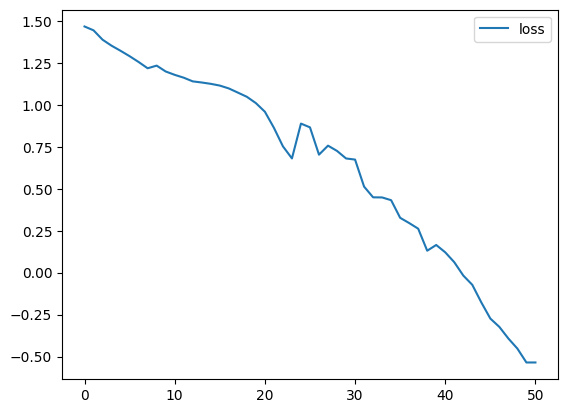

In [8]:
train_loss = Loss

plt.figure()
plt.plot(np.log(train_loss), label='loss')
plt.legend()

In [11]:
# Training performance

X_train = ag_train
y_train_ref = eta_train
yt_train_ref = eta_t_train
g_train_ref = -eta_tt_train-ag_train
# g_train_ref = -eta_tt_train-ag_train

# Prediction
ag_test_torch = torch.from_numpy(X_train).float()
ag_test_torch.requires_grad = True

model.eval()

output_star = model(ag_test_torch)
eta = output_star[:, :, 0:1]
eta_dot = output_star[:, :, 1:2]
g = output_star[:, :, 2:]

Phi_ut = Phi_t.reshape(1, eta.shape[1], eta.shape[1])
Phi_ut = Phi_ut.repeat(eta.shape[0], axis=0)
eta_t = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta)
eta_tt = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_dot)

lift_satr = eta_tt + g

eta_star, eta_t_star, eta_dot_star, g_star = eta, eta_t, eta_dot, g

eta_star = eta_star.detach().numpy()
eta_t_star = eta_t_star.detach().numpy()
eta_dot_star = eta_dot_star.detach().numpy()
g_star = g_star.detach().numpy()

y_train_pred = eta_star
yt_train_pred = eta_t_star
ydot_train_pred = eta_dot_star
g_train_pred = g_star

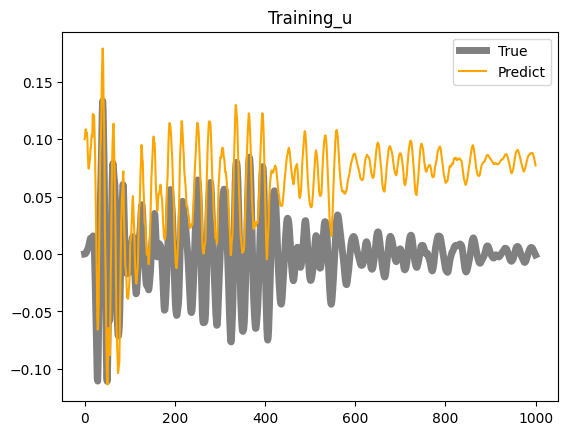

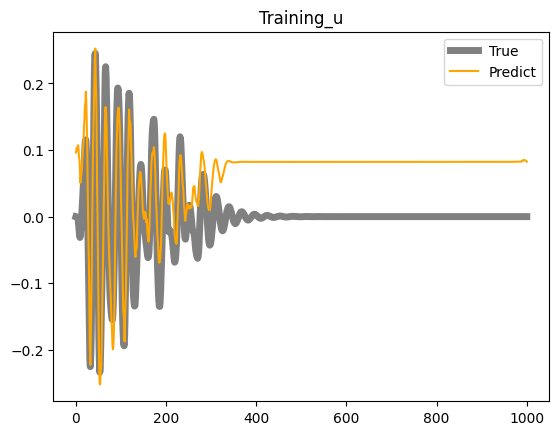

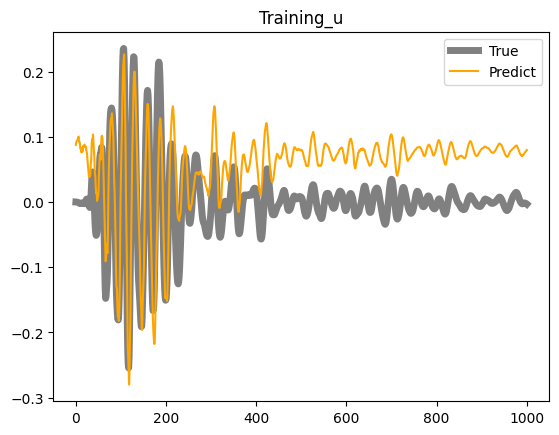

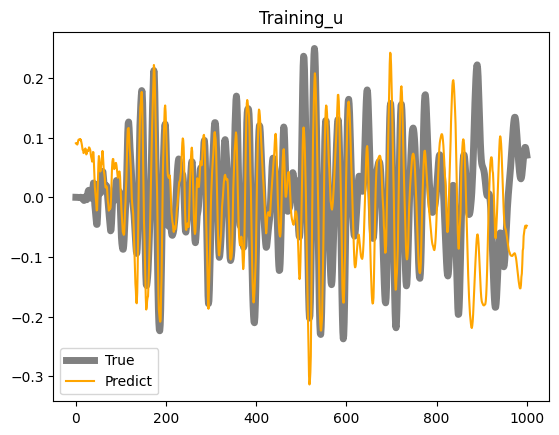

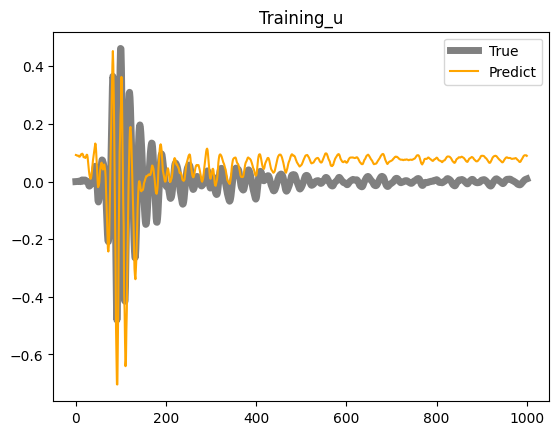

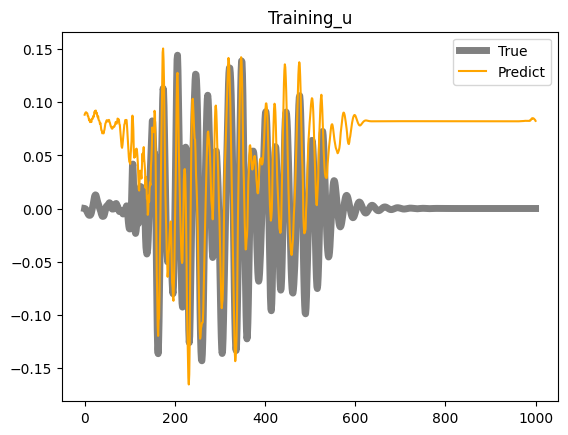

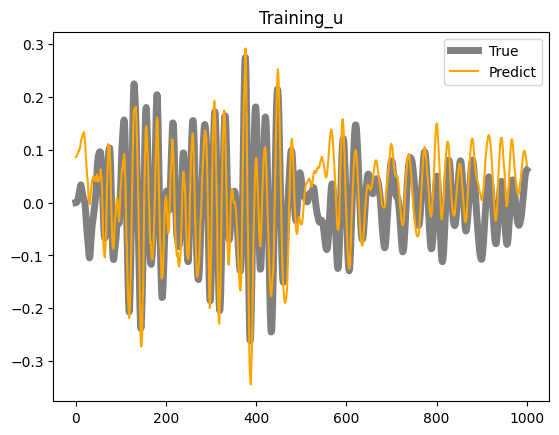

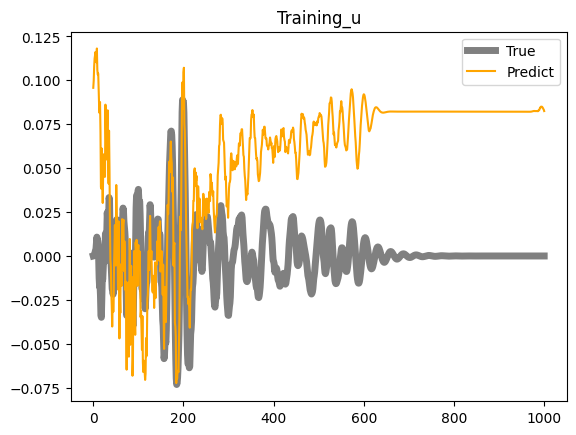

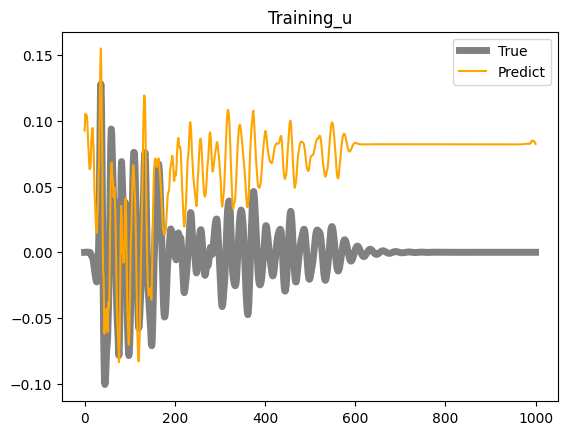

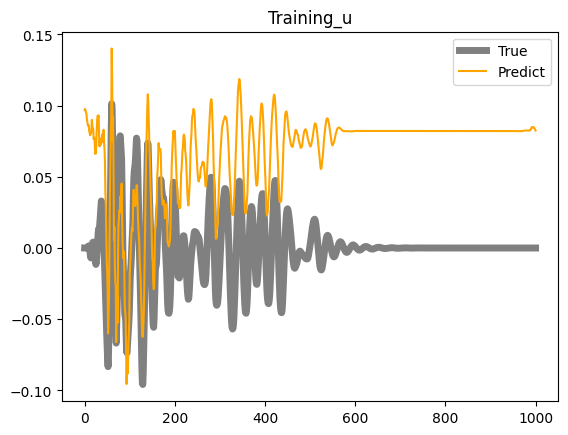

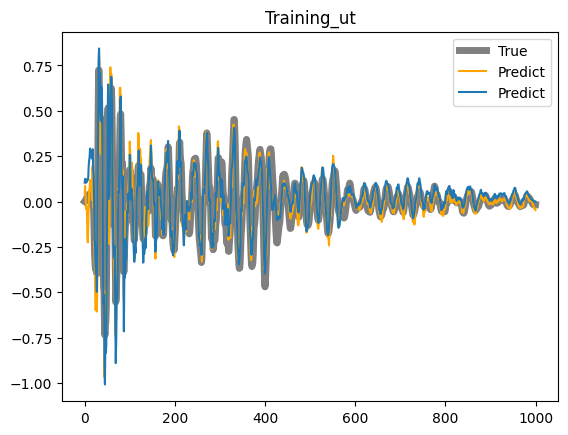

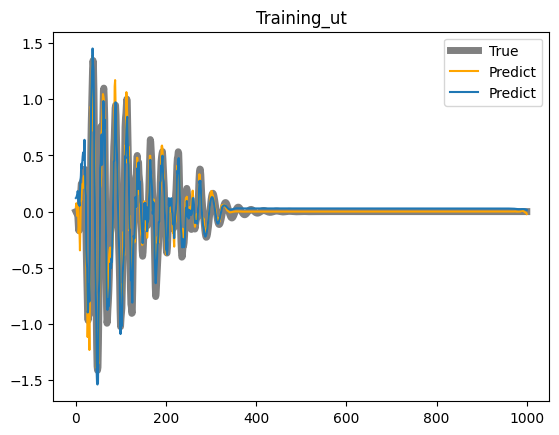

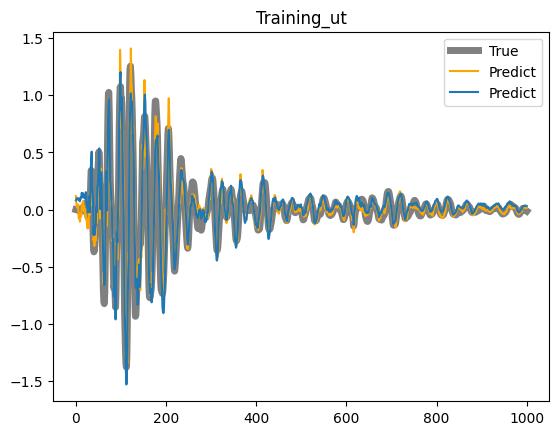

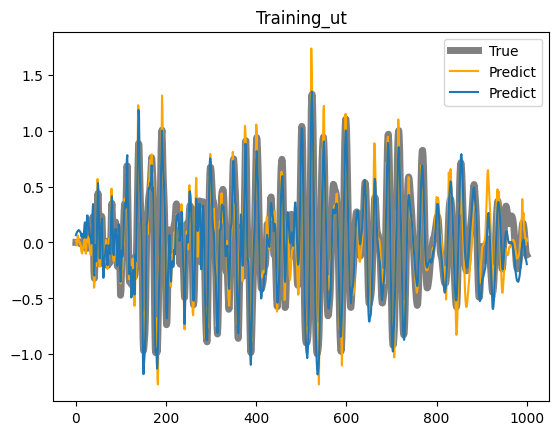

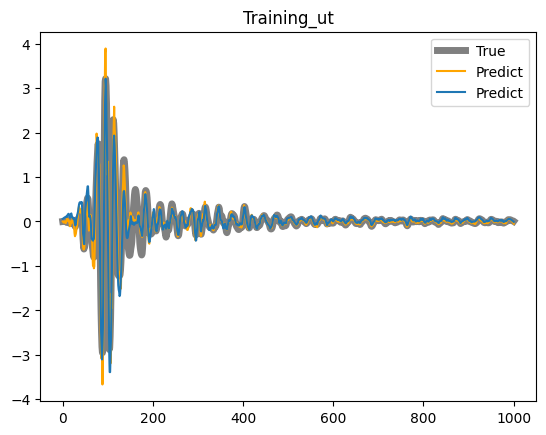

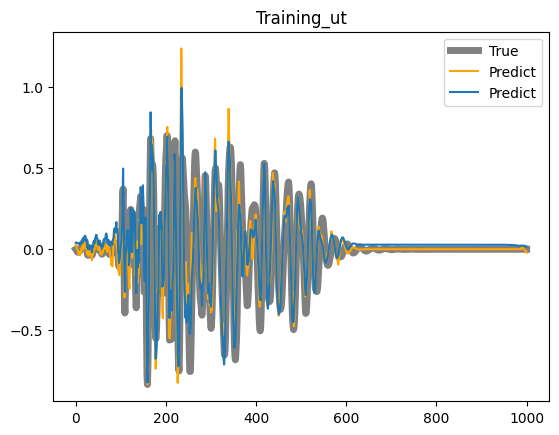

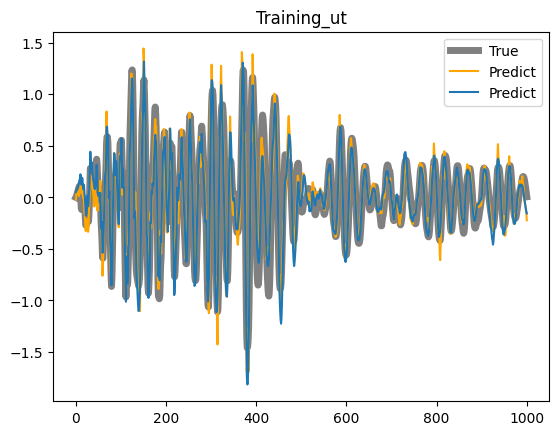

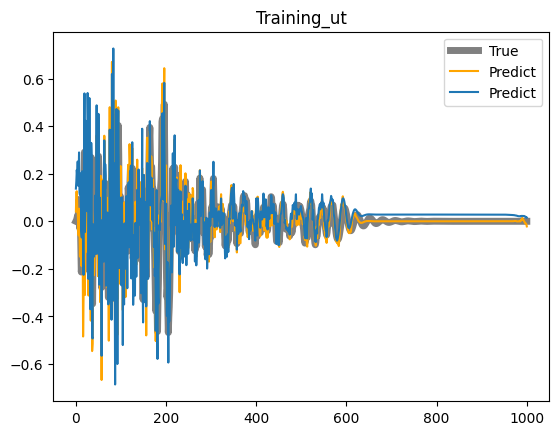

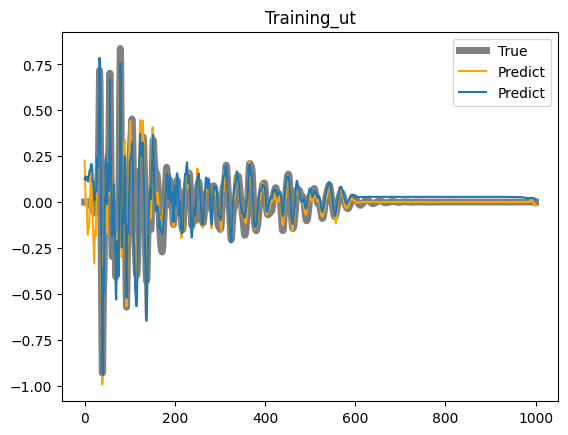

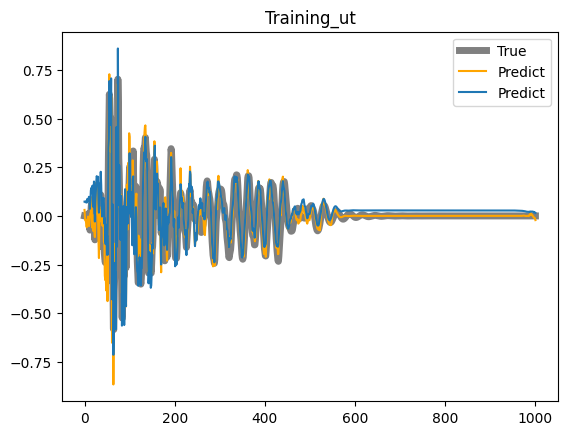

In [21]:

dof = 0
for n in range(len(ag_star)):
    plt.figure()
    plt.plot(y_train_ref[n, :, dof], 'gray', label='True', linewidth=3)
    plt.plot(y_train_pred[n, :, dof], 'orange', label='Predict')
    plt.title('Training_u')
    plt.legend()

for n in range(len(ag_star)):
    plt.figure()
    plt.plot(yt_train_ref[n, :, dof], 'gray', label='True',linewidth=3)
    plt.plot(yt_train_pred[n, :, dof], 'orange', label='Predict')
    plt.plot(ydot_train_pred[n, :, dof], label='Predict')
    plt.title('Training_ut')
    plt.legend()


In [13]:

 # Prediction performance
ag_pred = np.concatenate([mat['input_tf'], mat['input_pred_tf']])  # ag, ad, av
u_pred = np.concatenate([mat['target_X_tf'], mat['target_pred_X_tf']])
ut_pred = np.concatenate([mat['target_Xd_tf'], mat['target_pred_Xd_tf']])
utt_pred = np.concatenate([mat['target_Xdd_tf'], mat['target_pred_Xdd_tf']])
ag_pred = ag_pred.reshape([ag_pred.shape[0], ag_pred.shape[1], 1])
u_pred = u_pred.reshape([u_pred.shape[0], u_pred.shape[1], 1])
ut_pred = ut_pred.reshape([ut_pred.shape[0], ut_pred.shape[1], 1])
utt_pred = utt_pred.reshape([utt_pred.shape[0], utt_pred.shape[1], 1])

X_pred = ag_pred[10:]
y_pred_ref = u_pred[10:]
yt_pred_ref = ut_pred[10:]
ytt_pred_ref = utt_pred[10:]
g_pred_ref = -ytt_pred_ref-X_pred

Index_train = list(range(0, 10))

# Prediction
n_p = int(np.ceil(len(X_pred) / len(Index_train)))
y_pred = np.zeros(y_pred_ref.shape)
yt_pred = np.zeros(y_pred_ref.shape)
g_pred = np.zeros(g_pred_ref.shape)

In [ ]:
for jj in range(n_p):
    ind_str = len(Index_train) * jj
    ind_end = len(Index_train) * (jj + 1)
    
    x_in = torch.from_numpy(X_pred[ind_str:ind_end]).float()
    x_in.requires_grad = True

    output = model(x_in)
    
    eta = output[:, :, 0:1]
    eta_dot = output[:, :, 1:2]
    g = output[:, :, 2:]
    Phi_ut = Phi_t.reshape(1, eta.shape[1], eta.shape[1])
    Phi_ut = Phi_ut.repeat(eta.shape[0], axis=0)
    eta_t = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta)
    eta_tt = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_dot)

    eta = eta.detach().numpy()
    eta_t = eta_t.detach().numpy()
    eta_dot = eta_dot.detach().numpy()
    g = g.detach().numpy()

    y_pred[ind_str:ind_end] = eta
    yt_pred[ind_str:ind_end] = eta_t
    g_pred[ind_str:ind_end] = g

for ii in range(len(y_pred)):
    plt.figure()
    plt.plot(y_pred_ref[ii, :, dof],'gray', label='True', linewidth=3)
    plt.plot(y_pred[ii, :, dof], label='Predict')
    plt.title('Prediction_u')
    plt.legend()

    plt.figure()
    plt.plot(yt_pred_ref[ii],'gray', label='True', linewidth=3)
    plt.plot(yt_pred[ii], label='Predict')
    plt.title('Prediction_u_t')
    plt.legend()

    plt.figure()
    plt.plot(g_pred_ref[ii],'gray', label='True', linewidth=3)
    plt.plot(g_pred[ii], label='Predict')
    plt.title('Prediction_u_t')
    plt.legend()

    plt.figure()
    plt.plot(ytt_pred_ref[ii],'gray', label='True', linewidth=3)
    plt.title('Prediction_u_tt')
    plt.legend()

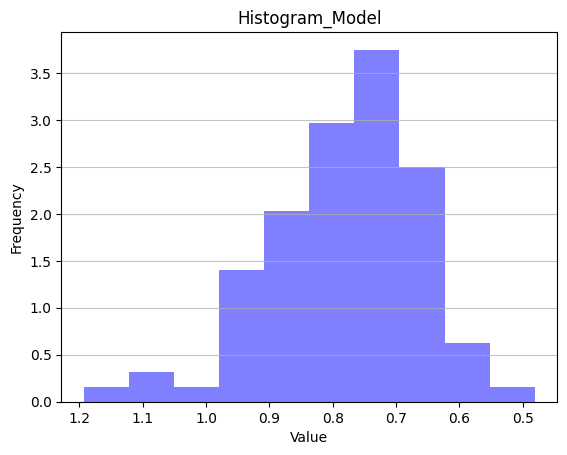

In [18]:
R1 = []
R2 = []
R3 = []
for ii in range(len(y_pred_ref)):
    reg1 = LinearRegression().fit(y_pred_ref[ii, :, 0:1], y_pred[ii, :, 0:1])
    R1.append(reg1.coef_)
R = np.concatenate([np.array(R1)])
R = R[:, 0]
plt.hist(R, 'auto', density=True, facecolor='blue', alpha=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram_Model')
ax = plt.gca()
ax.invert_xaxis()

In [ ]:

scipy.io.savemat(dataDir + 'results/results_num_ag2u.mat',
                {'y_train_ref': y_train_ref, 'yt_train_ref': yt_train_ref, 'g_train_ref': g_train_ref,
                'y_train_pred': y_train_pred, 'yt_train_pred': yt_train_pred, 'g_train_pred': g_train_pred,
                'y_pred_ref': y_pred_ref, 'yt_pred_ref': yt_pred_ref, 'g_pred_ref': g_pred_ref,
                'y_pred': y_pred, 'yt_pred': yt_pred, 'g_pred': g_pred,
                'X_train': X_train, 'X_pred': X_pred, 'time': t, 'dt': dt,
                'train_loss': train_loss})
